In [1]:
#! pip install -q tensorflow-model-optimization
#! pip install tensorflow-addons

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow.keras import backend as K
import tensorflow as tf
import random as rn
import os
import tensorflow.keras
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU, PReLU, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler

In [3]:
def set_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)
    # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    # K.set_session(sess)

# Cargo datos

In [4]:
folder = './'

In [5]:
X = np.load(folder+'train_images.npy').reshape(-1, 784)/255
y = np.loadtxt(folder+'train_labels.csv', delimiter=',', skiprows=1).reshape(-1, 1)
X_test = np.load(folder+'test_images.npy').reshape(-1, 784)/255
y_test = pd.read_csv(folder+'test_labels.csv')['Category'].values

# Red neuronal básica

In [6]:
def get_model(l1=1e-5, input_dim=784):
    output_size = 10
    # initializer = initializers.normal(mean=0, stddev=0.001)
    initializer = 'normal'
    # Creo el modelo
    model = Sequential()
    model.add(Dense(784*2, activation='linear', kernel_initializer=initializer, name='hidden_1', input_dim=input_dim,
                    kernel_regularizer=regularizers.l1(l=l1))) #
    model.add(BatchNormalization())
    model.add(PReLU())
    # model.add(Dropout(0.2))
    model.add(Dense(784, activation='linear', kernel_initializer=initializer, name='hidden_2', 
                    kernel_regularizer=regularizers.l1(l=l1)
                   ))
    model.add(BatchNormalization())
    model.add(PReLU())
#     model.add(Dense(400, activation='linear', kernel_initializer=initializer))
#     model.add(LeakyReLU())
    model.add(Dense(output_size, kernel_initializer=initializer, name='Salida'))
    model.add(Activation('softmax'))
    return model
model = get_model()
# model.save_weights('random-init.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 1568)              1230880   
_________________________________________________________________
batch_normalization (BatchNo (None, 1568)              6272      
_________________________________________________________________
p_re_lu (PReLU)              (None, 1568)              1568      
_________________________________________________________________
hidden_2 (Dense)             (None, 784)               1230096   
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 784)               784       
_________________________________________________________________
Salida (Dense)               (None, 10)                7

In [7]:
set_random_seeds(42)
batch_size = 256
lr = 0.001
epochs = 96


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = get_model(l1=0)
optim = optimizers.Adam(lr=lr)
rop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.2, patience=10, verbose=1)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=f'mlp.mnist_no_kfold.hdf5', 
                               verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
model.save_weights('initial_weights.hdf5')
history = model.fit(X_train, 
           y_train,
           epochs=epochs, batch_size=batch_size, 
          validation_data = (X_val, y_val),
           verbose=2, 
          callbacks=[checkpointer, rop],
                shuffle = True
          )

Epoch 1/96

Epoch 00001: val_accuracy improved from -inf to 0.85056, saving model to mlp.mnist_no_kfold.hdf5
200/200 - 1s - loss: 0.4257 - accuracy: 0.8470 - val_loss: 0.4116 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 2/96

Epoch 00002: val_accuracy improved from 0.85056 to 0.85967, saving model to mlp.mnist_no_kfold.hdf5
200/200 - 1s - loss: 0.3084 - accuracy: 0.8864 - val_loss: 0.3901 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 3/96

Epoch 00003: val_accuracy did not improve from 0.85967
200/200 - 1s - loss: 0.2583 - accuracy: 0.9045 - val_loss: 0.4427 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 4/96

Epoch 00004: val_accuracy improved from 0.85967 to 0.87000, saving model to mlp.mnist_no_kfold.hdf5
200/200 - 1s - loss: 0.2288 - accuracy: 0.9139 - val_loss: 0.3492 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 5/96

Epoch 00005: val_accuracy did not improve from 0.87000
200/200 - 1s - loss: 0.2004 - accuracy: 0.9251 - val_loss: 0.6444 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 6/96

Epoch 00006

In [8]:
model.evaluate(X_val, y_val, verbose=0)

[0.5716524124145508, 0.9068889021873474]

In [12]:
model.load_weights('mlp.mnist_no_kfold.hdf5')
print(model.evaluate(X_val, y_val, verbose=0))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.evaluate(X_test, y_test, verbose=0)

[0.5521948337554932, 0.9087777733802795]


[0.60569828748703, 0.9035000205039978]

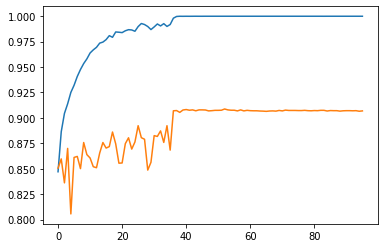

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [14]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras.layers import Input

In [69]:
sparcity = 0.50
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
sprasity_sched = tfmot.sparsity.keras.ConstantSparsity(
    sparcity, 0, end_step=-1, frequency=10000000)

In [70]:
print([layer.name for layer in model.layers])

['hidden_1', 'batch_normalization_2', 'p_re_lu_2', 'hidden_2', 'batch_normalization_3', 'p_re_lu_3', 'Salida', 'activation_1']


In [71]:
model.load_weights('mlp.mnist_no_kfold.hdf5')
layer_to_pune = ['hidden_1', 'hidden_2', 'Salida']
prunned_model_layers = []
for layer in model.layers:
    if layer.name in layer_to_pune:
        prunned_model_layers.append(prune_low_magnitude(layer, sprasity_sched))
    else:
        prunned_model_layers.append(layer)
pruned_model_trained = keras.Sequential(prunned_model_layers)
pruned_model_trained.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-10), metrics=['accuracy'])
pruned_model_trained.evaluate(X_test, y_test, verbose=0)

[0.60569828748703, 0.9035000205039978]

In [72]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
    #CyclicLR(1e-9, 0.001, 2*iters_per_epoch, mode='triangular'),
    ModelCheckpoint(filepath=f'mlp.mnist_no_kfold_sparse.hdf5', verbose=1, save_best_only=True, monitor='val_accuracy', mode='max'),
#    tfmot.sparsity.keras.PruningSummaries(log_dir='logs'),
]

In [73]:
pruned_model_trained.fit(X_train, 
               y_train,
               epochs=1, batch_size=batch_size, 
              validation_data = (X_val, y_val),
               verbose=2, 
                    shuffle = True,
                           callbacks=callbacks
              )


Epoch 00001: val_accuracy improved from -inf to 0.90589, saving model to mlp.mnist_no_kfold_sparse.hdf5
200/200 - 1s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4977 - val_accuracy: 0.9059


In [74]:
print([layer.name for layer in pruned_model_trained.layers])

['prune_low_magnitude_hidden_1', 'batch_normalization_2', 'p_re_lu_2', 'prune_low_magnitude_hidden_2', 'batch_normalization_3', 'p_re_lu_3', 'prune_low_magnitude_Salida', 'activation_1']


In [75]:
mask = pruned_model_trained.get_layer('prune_low_magnitude_hidden_1').pruning_vars[0][1]

In [76]:
model.load_weights('mlp.mnist_no_kfold.hdf5')
weights_abs = np.abs(model.get_layer('hidden_1').get_weights()[0])
print(np.min(weights_abs[mask==1]) > np.max(weights_abs[mask==0]))

True


In [77]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

In [78]:
model.load_weights('initial_weights.hdf5')
for i, layer in enumerate(pruned_model_trained.layers):
    if isinstance(layer, pruning_wrapper.PruneLowMagnitude):
        print(i)
        l_weights = model.layers[i].get_weights()
        l_weights[0] = l_weights[0]*layer.pruning_vars[0][1].numpy()
        model.layers[i].set_weights(l_weights)

0
3
6


In [79]:
l_index = 6
(model.layers[l_index].get_weights()[0] == 0).sum()/np.product(model.layers[l_index].get_weights()[0].shape)

0.5

In [80]:
prunned_model_layers = []
for layer in model.layers:
    if layer.name in layer_to_pune:
        prunned_model_layers.append(prune_low_magnitude(layer, sprasity_sched))
    else:
        prunned_model_layers.append(layer)
pruned_model = keras.Sequential(prunned_model_layers)
pruned_model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=lr), metrics=['accuracy'])
pruned_model.evaluate(X_test, y_test, verbose=0)

[1.3031542301177979, 0.6588000059127808]

In [81]:
pruned_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_hidden_1 (None, 1568)              2460194   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1568)              6272      
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 1568)              1568      
_________________________________________________________________
prune_low_magnitude_hidden_2 (None, 784)               2459410   
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 784)               784       
_________________________________________________________________
prune_low_magnitude_Salida ( (None, 10)              

In [82]:
(pruned_model.layers[l_index].pruning_vars[0][1].numpy() == pruned_model_trained.layers[l_index].pruning_vars[0][1].numpy()).sum()/np.product(model.layers[l_index].get_weights()[0].shape)

0.5

In [84]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
    ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=np.sqrt(0.1), patience=10, verbose=1),
    ModelCheckpoint(filepath=f'mlp.mnist_no_kfold_sparse.hdf5', verbose=1, save_best_only=True, monitor='val_accuracy', mode='auto'),
   # tfmot.sparsity.keras.PruningSummaries(log_dir='logs'),
]

In [85]:
history = pruned_model.fit(X_train, 
               y_train,
               epochs=96, batch_size=batch_size, 
              validation_data = (X_val, y_val),
               verbose=0, 
                    shuffle = True,
                           callbacks=callbacks
              )


Epoch 00001: val_accuracy improved from -inf to 0.85522, saving model to mlp.mnist_no_kfold_sparse.hdf5

Epoch 00002: val_accuracy improved from 0.85522 to 0.87878, saving model to mlp.mnist_no_kfold_sparse.hdf5

Epoch 00003: val_accuracy did not improve from 0.87878

Epoch 00004: val_accuracy did not improve from 0.87878

Epoch 00005: val_accuracy did not improve from 0.87878

Epoch 00006: val_accuracy improved from 0.87878 to 0.88267, saving model to mlp.mnist_no_kfold_sparse.hdf5

Epoch 00007: val_accuracy did not improve from 0.88267

Epoch 00008: val_accuracy did not improve from 0.88267

Epoch 00009: val_accuracy did not improve from 0.88267

Epoch 00010: val_accuracy did not improve from 0.88267

Epoch 00011: val_accuracy improved from 0.88267 to 0.88756, saving model to mlp.mnist_no_kfold_sparse.hdf5

Epoch 00012: val_accuracy did not improve from 0.88756

Epoch 00013: val_accuracy did not improve from 0.88756

Epoch 00014: val_accuracy did not improve from 0.88756

Epoch 0001

In [86]:
pruned_model_trained.evaluate(X_test, y_test, verbose=0)

[0.6913381814956665, 0.9054999947547913]

In [265]:
(pruned_model.layers[1].pruning_vars[0][1].numpy() == pruned_model_trained.layers[1].pruning_vars[0][1].numpy()).sum()/np.product(model.layers[1].get_weights()[0].shape)

1.0

In [266]:
pruned_model.load_weights('mlp.mnist_no_kfold_sparse.hdf5')
pruned_model.evaluate(X_test, y_cat_test, verbose=0)

[0.5937738418579102, 0.9045555591583252]

In [267]:
pruned_model.evaluate(x_test_ok, y_test_ok_cat, verbose=0)

[0.6598390340805054, 0.8964999914169312]

In [230]:
h1 = pruned_model.get_layer('prune_low_magnitude_hidden_1')
h2 = pruned_model.get_layer('prune_low_magnitude_hidden_2')

In [231]:
(np.abs(h1.get_weights()[0].reshape(-1))>0).sum()/len(h1.get_weights()[0].reshape(-1))

0.5

In [232]:
(np.abs(h2.get_weights()[0].reshape(-1))>0).sum()/len(h2.get_weights()[0].reshape(-1))

0.5

In [233]:
model.layers[1].set_weights(h1.get_weights())
model.layers[4].set_weights(h2.get_weights())

In [234]:
model.evaluate(X_test, y_cat_test, verbose=0)

[0.6078376770019531, 0.9085555672645569]

In [222]:
(model.layers[1].get_weights()[0] == 0).sum()/ len(model.layers[1].get_weights()[0].reshape(-1))

0.75

In [ ]:
preds_val = np.zeros_like(y_cat)

In [ ]:
if n_splits > 1:
    test_preds = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for i, (train_index, test_index) in enumerate(skf.split(x, y)):
        model.load_weights(f'mlp.mnist_{i}.hdf5') 
        loss, acc = model.evaluate(x[test_index], y_cat[test_index])
        preds_val[test_index] = model.predict(x[test_index])
        test_preds = test_preds + model.predict(x_test)
        print(acc)
else:
    test_preds = model.predict(x_test)

In [ ]:
# Valid Acc
(np.argmax(preds_val, axis=1) == y).sum()/len(y)

In [ ]:
test_labels = np.argmax(test_preds, axis = 1)

In [ ]:
import pandas
df = pandas.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("./submission.csv", sep=',',index=True,  index_label='Id')

In [ ]:
df.head()